In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import inv as inv
import matplotlib.pyplot as plt
from scipy.stats import norm as norm
from sklearn.model_selection import train_test_split

In [2]:
def plot_pdfs(mean1, mean2, std1, std2, threshold, dataset_name):
    # change X limits for pdf plot to -3 to 3 if normalised W is used. Otherwise set it to -30 to 30 
    X_axis = np.linspace(-3.0,3.0,100000)
    plt.plot(X_axis, norm.pdf(X_axis, mean1, std1),'-', color='b',label='Class 1 (value 1)')    
    plt.plot(X_axis, norm.pdf(X_axis, mean2, std2),'-', color='r',label='Class 2 (value 0)')
    plt.plot([threshold], norm.pdf([threshold], mean1, std1), '.', color='g',label='Threshold')
    plt.legend(loc = 'upper right')
    plt.title('Normal distributions. Threshold = '+ str(threshold))
    plt.savefig('plots/' + str(dataset_name) + '_FldaNormDistribution.png')
    plt.show()

In [3]:
def plot_projections(projections, y_test, threshold, dataset_name):
    proj_pred_data = pd.DataFrame(np.concatenate((projections, y_test), axis=1))
    proj1_pred = proj_pred_data.loc[proj_pred_data[1] == 1][[0]]
    proj2_pred = proj_pred_data.loc[proj_pred_data[1] == 0][[0]]    
    plt.plot(proj1_pred, np.ones(proj1_pred.shape), '.', color='b', label='Class 1 (value 1)')
    plt.plot(proj2_pred, np.ones(proj2_pred.shape), '.', color='r',label='Class 2 (value 0)')
    plt.plot([threshold], [1], '.', color='g',label='Threshold')
    plt.legend(loc = 'upper right')
    plt.title('Projections onto W vector. Threshold = '+ str(threshold))
    plt.savefig('plots/' + str(dataset_name) + '_FldaProjections.png')
    plt.show()

In [4]:
def solve_pdfs(pdf_mean_1, pdf_mean_2, pdf_std_1, pdf_std_2):
    coeff1 = 1/(2*pdf_std_1**2) - 1/(2*pdf_std_2**2)
    coeff2 = pdf_mean_2/(pdf_std_2**2) - pdf_mean_1/(pdf_std_1**2)
    coeff3 = pdf_mean_1**2 /(2*pdf_std_1**2) - pdf_mean_2**2 / (2*pdf_std_2**2) - np.log(pdf_std_2/pdf_std_1)

    coeffs = [coeff1, coeff2, coeff3]

    roots_of_eq = np.roots(coeffs)
    threshold = roots_of_eq[1]
    return threshold

In [5]:
def find_w_cordinates(X_train1, X_train2):
    
    # 1. Find M1, M2, Cov1, Cov2
    Mean1 = np.mean(X_train1,axis=0)
    Mean2 = np.mean(X_train2,axis=0)
    Mean_difference = np.subtract(Mean1,Mean2)

    Cov1 = np.cov(np.transpose(X_train1))
    Cov2 = np.cov(np.transpose(X_train2))

    # 2. Within class spread Sw = Cov1 + Cov2  
    Sw_inv = np.linalg.inv(np.add(Cov1,Cov2))
    
    # 3. W = (Sw_inv).(M1-M2)
    W = np.dot(Sw_inv,Mean_difference)
    
    # 4. Normalise W
    W_norm = W / np.linalg.norm(W)
    
    # Note:
    # change X limits for pdf plot to -30 to 30 if W is used
    # change X limits for pdf plot to -3 to 3 if normalised W is used
    
    return W_norm

In [6]:
def find_threshold(X_train1, X_train2, W, dataset_name):
    # Threshold = point of intersection of the pdfs (probability density functions)
    
    # 1. Find Projections
    Proj1 = np.dot(W,X_train1.transpose())
    Proj2 = np.dot(W,X_train2.transpose())
    
    # 2. Find Means of the projected data for class 1 and 2
    proj_mean1 = np.mean(Proj1)
    proj_mean2 = np.mean(Proj2)

    # 3. Find Std deviations of the projected data for class 1 and 2
    proj_std1 = np.std(Proj1)
    proj_std2 = np.std(Proj2)

    # 4. Solve the equations
    threshold = solve_pdfs(proj_mean1, proj_mean2, proj_std1, proj_std2)
    
    # Plot the pdfs
    plot_pdfs(proj_mean1, proj_mean2, proj_std1, proj_std2, threshold, dataset_name)
    return threshold

In [7]:
def find_predictions(X_test, W, threshold):
    
    # Project the Test data onto W
    proj_testdata = np.dot(W, X_test.transpose()).reshape(X_test.shape[0],1)
    
    # Compare with threshold
    predictions = (proj_testdata >= threshold).astype(int).reshape(X_test.shape[0],1)
    
    return proj_testdata, predictions

In [8]:
def accuracy(actual, predicted):
    # Accuracy = (TP + TN)/(TP + TN + FP + FN)
    
    return np.mean((actual == predicted).astype(int))

In [9]:
def precision(actual, predicted):
    # Precision = (TP)/(TP + FP) = True pos out of the actual results
    
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FP = np.count_nonzero(np.logical_and((actual == 0) , (predicted == 1)).astype(int))
    return TP/(TP + FP)

In [10]:
def recall(actual, predicted):
    # Recall = (TP)/(TP + FN) = True pos out of the predicted results
    
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FN = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 0)).astype(int))
    return TP/(TP + FN)

In [11]:
def f_score(actual , predicted):
    # F_Score = 2PR/(P+R)
    
    P = precision(actual, predicted)
    R = recall(actual, predicted)
    return 2*P*R/(P + R)

In [12]:
def fisher(X_train1, X_train2, X_test, y_test, dataset_name):
    
    # 1. Find Projection Line
    W = find_w_cordinates(X_train1, X_train2)
    
    # 2. Find Threshold
    threshold = find_threshold(X_train1, X_train2, W, dataset_name)
    
    # 3. Find Predictions for the Test Data by Projecting onto W and comparing to the threshold
    projections, y_predicted = find_predictions(X_test, W, threshold)
    
    # Plot the projections
    plot_projections(projections, y_test, threshold, dataset_name)
    
    print('W',W)
    print('Threshold:',threshold)
    print('accuracy:',accuracy(y_test , y_predicted))
    print('precision:',precision(y_test , y_predicted))
    print('recall:',recall(y_test , y_predicted))
    print('f_score:',f_score(y_test , y_predicted)) 

# DATASET - 1

TESTCASE - 1


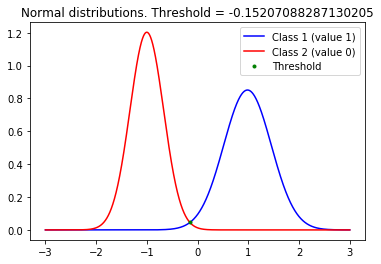

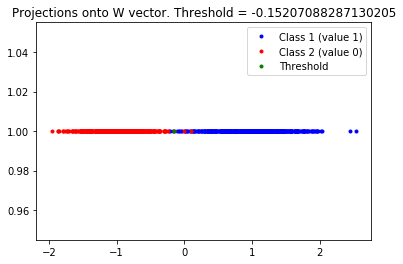

W [0.03304637 0.99945382]
Threshold: -0.15207088287130205
accuracy: 0.993
precision: 0.9939879759519038
recall: 0.992
f_score: 0.9929929929929929


In [13]:
data = pd.read_csv('data/a1_d1.csv', header=None)

"""
N = total number of points in the given dataset

X = [
     [f1, f2, f3, ..] (1),
     [f1, f2, f3, ..] (2),
     [..............] (.),
     [..............] (.),
     [..............] (N)
    ]
    
y = [label1, label2, label3, ....labelN]

"""

# X => Feature vectors of all the points in the given dataset
# y => Corresponding labels

X = data[[0,1]]
y = data[[2]]

# label = 1 -> Class 1
# label = 0 -> Class 2

# X_1 => Feature vectors of all the points in class1
# X_2 => Feature vectors of all the points in class2

X_1 = data.loc[data[2]==1][[0,1]]
X_2 = data.loc[data[2]==0][[0,1]]

print('TESTCASE - 1')

fisher(X_1, X_2, X, y.values, "a1_d1")

# DATASET - 2

TESTCASE - 2


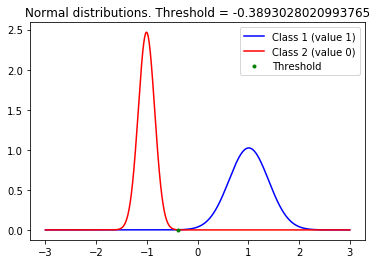

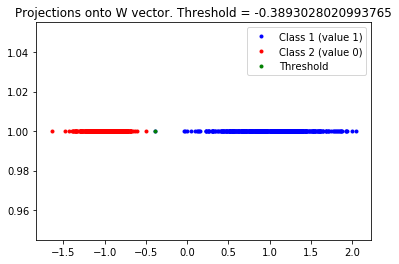

W [-0.00655686 -0.01823739  0.99981218]
Threshold: -0.3893028020993765
accuracy: 1.0
precision: 1.0
recall: 1.0
f_score: 1.0


In [14]:
data = pd.read_csv('data/a1_d2.csv', header=None)

"""
N = total number of points in the given dataset

X = [
     [f1, f2, f3, ..] (1),
     [f1, f2, f3, ..] (2),
     [..............] (.),
     [..............] (.),
     [..............] (N)
    ]
    
y = [label1, label2, label3, ....labelN]

"""

# X => Feature vectors of all the points in the given dataset
# y => Corresponding labels

X = data[[0,1,2]]
y = data[[3]]

# label = 1 -> Class 1
# label = 0 -> Class 2

# X_1 => Feature vectors of all the points in class1
# X_2 => Feature vectors all the points in class2

X_1 = data.loc[data[3]==1][[0,1,2]]
X_2 = data.loc[data[3]==0][[0,1,2]]

print('TESTCASE - 2')
fisher(X_1, X_2, X, y.values, "a1_d2")